# Project 5: Predicting Net Revenue for Buffer
## Katie Fan
## Modeling

index
1. Load Data
2. Check for Autocorrelation & Stationarity of Net Revenue
 - 2.1 EDA on Net Revenue
 - 2.2 Autocorrelation
 - 2.3 Stationarity
 - 2.4 Reduce Trend and Seasonality
   - 2.4.1 Resampling by Week
   - 2.4.2 Log Transformation

3. Try to Get Some Ideas about Parameters for SARIMA Model
 - 3.1 AR(p)
 - 3.2 MA(q)
 - 3.3 ARMA(p,q)
 - 3.4 ARIMA(p,d,q)
4. SARIMA Model
 - 4.1 Find Optimal Parameters
 - 4.2 SARIMA Model
5. SARIMAX Model with Coupons as External Variable

## 1. Load Data

In [1]:
# import packages 
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pandas.tools.plotting import lag_plot
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import itertools
import datetime as dt

In [2]:
# import data
df = pd.read_pickle('/Users/katiefan/Documents/projects/project-5/df_buffer.pkl')

In [3]:
df.columns.tolist()

['date',
 'mrr',
 'net_revenue',
 'fees',
 'other_revenue',
 'arpu',
 'arr',
 'ltv',
 'mrr_growth_rate',
 'user_churn',
 'revenue_churn',
 'net_revenue_churn',
 'quick_ratio',
 'active_customers',
 'new_customers',
 'reactivations',
 'new_subscriptions',
 'active_subscriptions',
 'plan_quantities',
 'upgrades',
 'downgrades',
 'cancellations',
 'churned_customers',
 'coupons',
 'failed_charges',
 'refunds']

In [4]:
# convert date to DateTime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
# sort dates to ascending and view
df.sort_index(inplace=True)
df.head()

,mrr,net_revenue,fees,other_revenue,arpu,arr,ltv,mrr_growth_rate,user_churn,revenue_churn,...,new_subscriptions,active_subscriptions,plan_quantities,upgrades,downgrades,cancellations,churned_customers,coupons,failed_charges,refunds
date,,,,,,,,,,,,,,,,,,,,,
2012-01-25,0.0,10.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-26,0.0,20.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-27,137.0,384.0,12.00,294.0,9.79,1644.0,353.0,0.0,0.0,0.0,...,14.0,14.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-01-28,285.0,271.0,8.79,241.0,14.23,3414.0,514.0,0.0,0.0,0.0,...,6.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-29,353.0,172.0,6.21,152.0,13.07,4236.0,472.0,0.0,0.0,0.0,...,7.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# EDA of the dataset
df.describe().round(2)

,mrr,net_revenue,fees,other_revenue,arpu,arr,ltv,mrr_growth_rate,user_churn,revenue_churn,...,new_subscriptions,active_subscriptions,plan_quantities,upgrades,downgrades,cancellations,churned_customers,coupons,failed_charges,refunds
count,2687.00,2687.00,2687.00,2687.00,2687.00,2687.00,2687.00,2687.00,2687.00,2687.00,...,2687.00,2687.00,2687.00,2687.00,2687.0,2687.00,2687.00,2687.00,2687.00,2687.00
mean,711250.25,24542.58,765.45,46.96,14.87,8535003.42,249.98,11.34,7.06,8.06,...,107.62,41924.78,42130.37,6.31,5.0,80.63,79.77,729.89,175.17,1081.25
std,537816.95,18451.14,516.51,249.28,3.63,6453802.72,97.04,93.08,6.11,6.62,...,66.12,26375.76,26614.77,5.98,8.5,58.27,57.27,909.62,100.02,1407.14
min,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
25%,177535.00,6924.00,302.00,0.00,11.87,2130422.00,159.50,1.70,5.40,6.40,...,56.00,16310.50,16310.50,1.00,1.0,35.00,33.00,10.00,84.00,26.00
50%,657886.00,22233.00,737.00,0.00,14.39,7894627.00,254.00,3.90,5.80,6.70,...,100.00,45520.00,45520.00,5.00,4.0,83.00,83.00,354.00,200.00,435.00
75%,1228025.50,39773.00,1215.00,20.00,17.44,14736309.00,312.00,8.20,6.90,7.60,...,153.00,70487.50,70744.00,10.00,8.0,117.00,116.00,1180.50,258.00,1770.00
max,1637156.00,145481.00,4149.00,7395.00,22.80,19645867.00,514.00,3908.90,71.70,77.70,...,607.00,75582.00,76254.00,74.00,283.0,722.00,702.00,6295.00,524.00,12131.00


## 2. Check for Autocorrelation & Stationarity of Net Revenue
## 2.1 EDA on Net Revenue

## Plot of Net Revenue

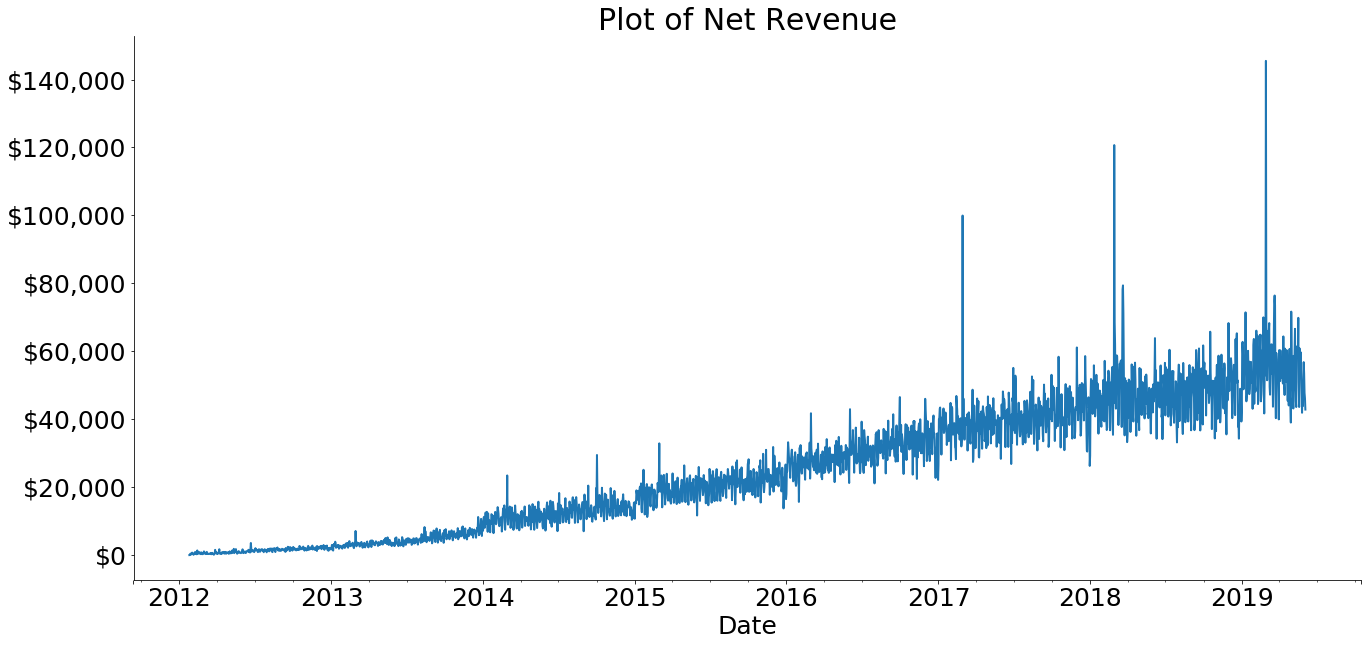

In [7]:
# plot of net revenue 2012-2019
ax = df.net_revenue.plot(linewidth=2, figsize=(22, 10), fontsize=25)
plt.title('Plot of Net Revenue', fontsize=30)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Date', fontsize=25)
sns.despine()
plt.savefig("prj5 Net Revenue.svg")

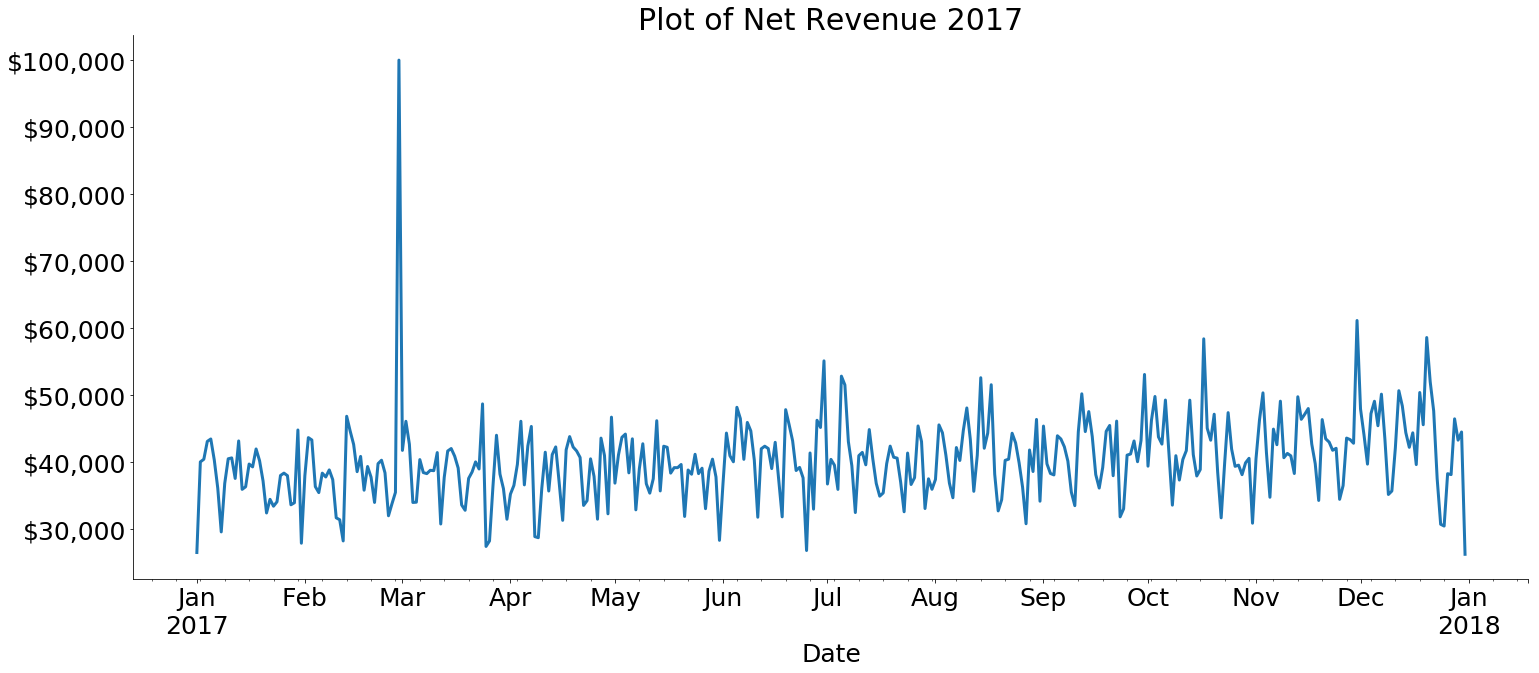

In [8]:
# take a look at 2017
# plot of net revenue in 2017
ax = df.net_revenue['2017-01-01':'2017-12-31'].plot(linewidth=3, figsize=(25, 10), fontsize=25)
plt.title('Plot of Net Revenue 2017', fontsize=30)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Date', fontsize=25)
sns.despine()

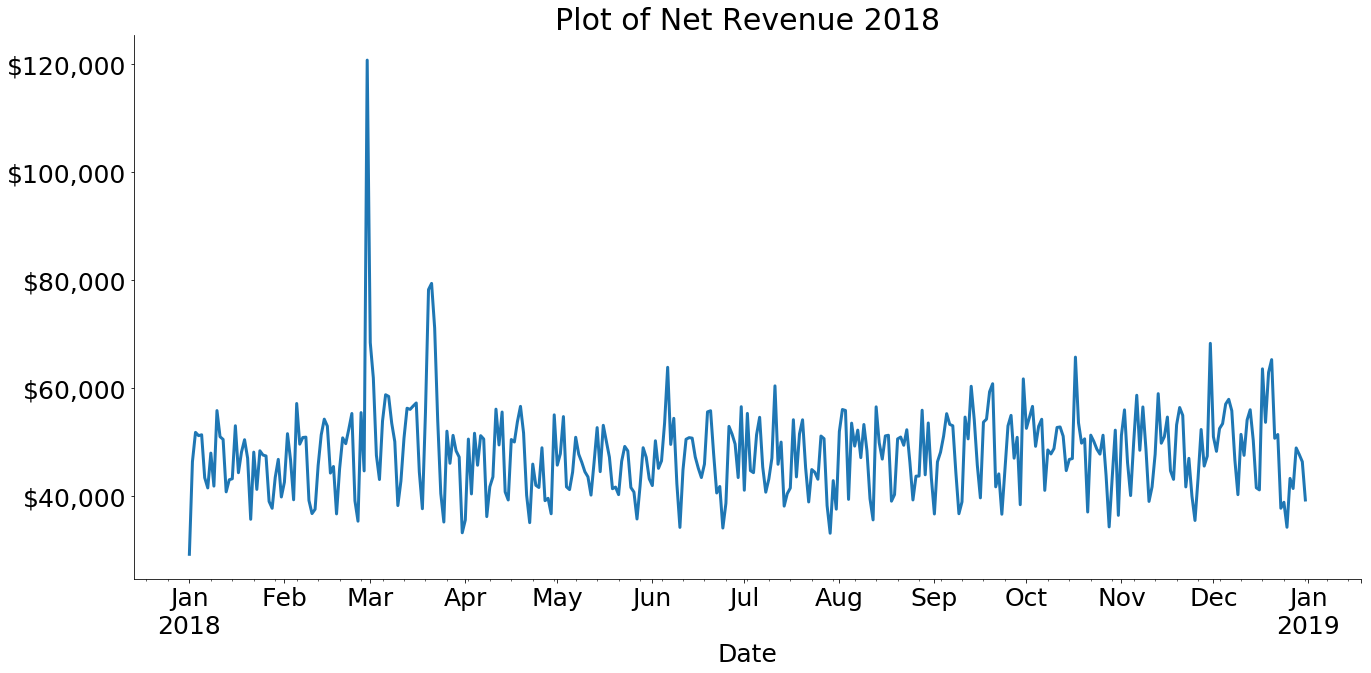

In [9]:
# take a look at 2018
# plot of net revenue in 2018
ax = df.net_revenue['2018-01-01':'2018-12-31'].plot(linewidth=3, figsize=(22, 10), fontsize=25)
plt.title('Plot of Net Revenue 2018', fontsize=30)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Date', fontsize=25)
sns.despine()
plt.savefig("prj5 Net Revenue 2018.svg")

## 2.2 Autocorrelation

In [10]:
# define a function to plot ACF and PACF results
def acf_pacf_plot(data):
    """
    display ACF and PACF plots in one row
    """
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig = plot_acf(data, lags=50, ax=axes[0])
    fig = plot_pacf(data, lags=50, ax=axes[1])
    sns.despine()

## Lag Plot of Net Revenue

/Users/katiefan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


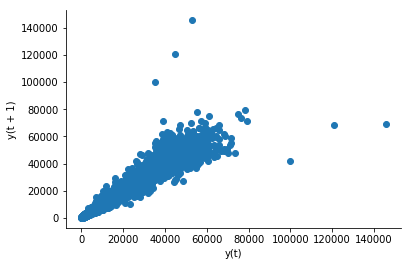

In [11]:
# check for autocorrelation
lag_plot(df.net_revenue)
sns.despine()

## Autocorrelation Plot of Net Revenue

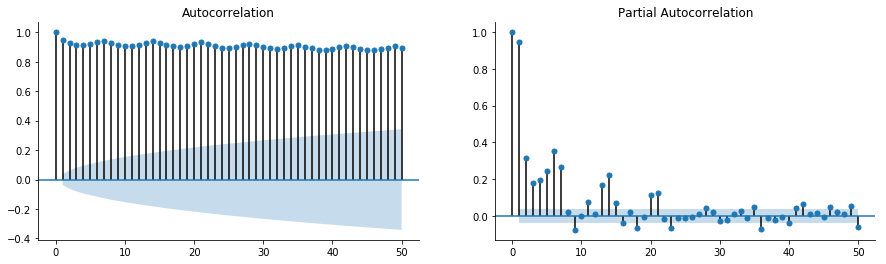

In [12]:
# check for autocorrelation and partial autocorrelation
acf_pacf_plot(df.net_revenue)

## 2.3 Stationarity

In [13]:
# define a function to display results of ADF (Augmented Dickey Fuller) Test
def adf_test(data):
    """
    print test statistic, p-vaue, number of lags used, number of observations used, and critical values from the Results of Dickey-Fuller Test
    """
    print('Results of Dickey-Fuller Test:')
    res = adfuller(data, autolag='AIC')
    print('\nTest Statistic: %.4f' % res[0])
    print('P-value: %.4f' % res[1])
    print('# of Lags Used: %.0f' % res[2])
    print('# of Obs Used: %.0f' % res[3])
    for k, v in res[4].items():
        print('Critical Value %s: %.4f' % (k, v))

## Decomposition of Net Revenue

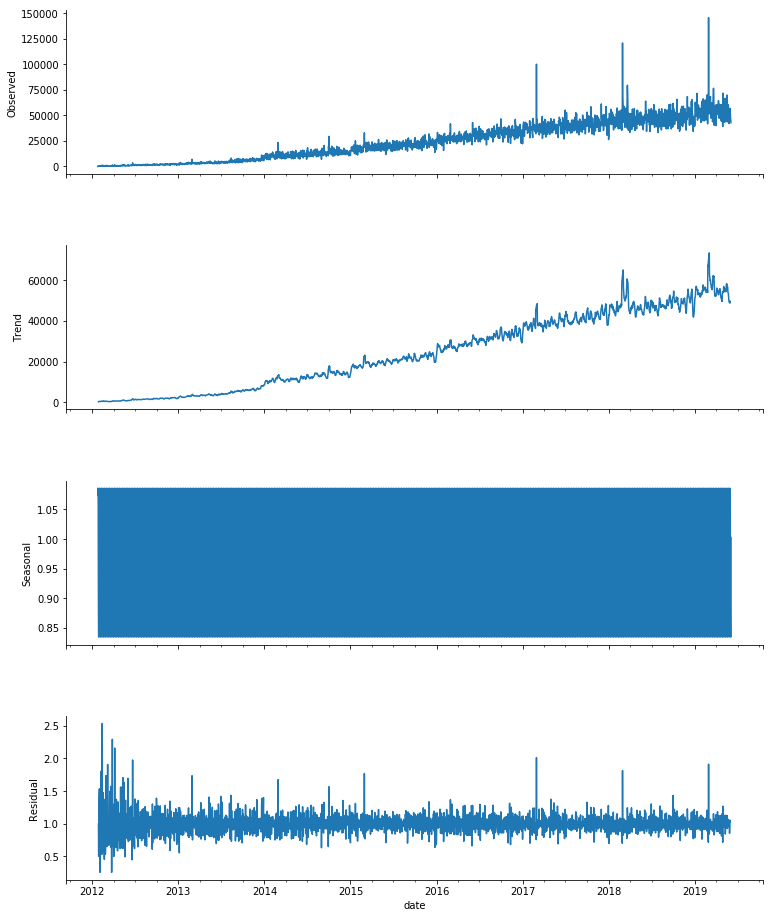

In [14]:
# multiplicative seasonal decomposing
decomposition = seasonal_decompose(df.net_revenue, model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(12, 15)
sns.despine()

## Dickey-Fuller Test for Net Revenue

In [15]:
# ADF (Augmented Dickey Fuller) Test for net revenue
adf_test(df.net_revenue)

Results of Dickey-Fuller Test:

Test Statistic: -0.3219
P-value: 0.9223
# of Lags Used: 28
# of Obs Used: 2658
Critical Value 1%: -3.4328
Critical Value 5%: -2.8626
Critical Value 10%: -2.5673


## 2.4 Reduce Trend and Seasonality
### 2.4.1 Resampling by Week 

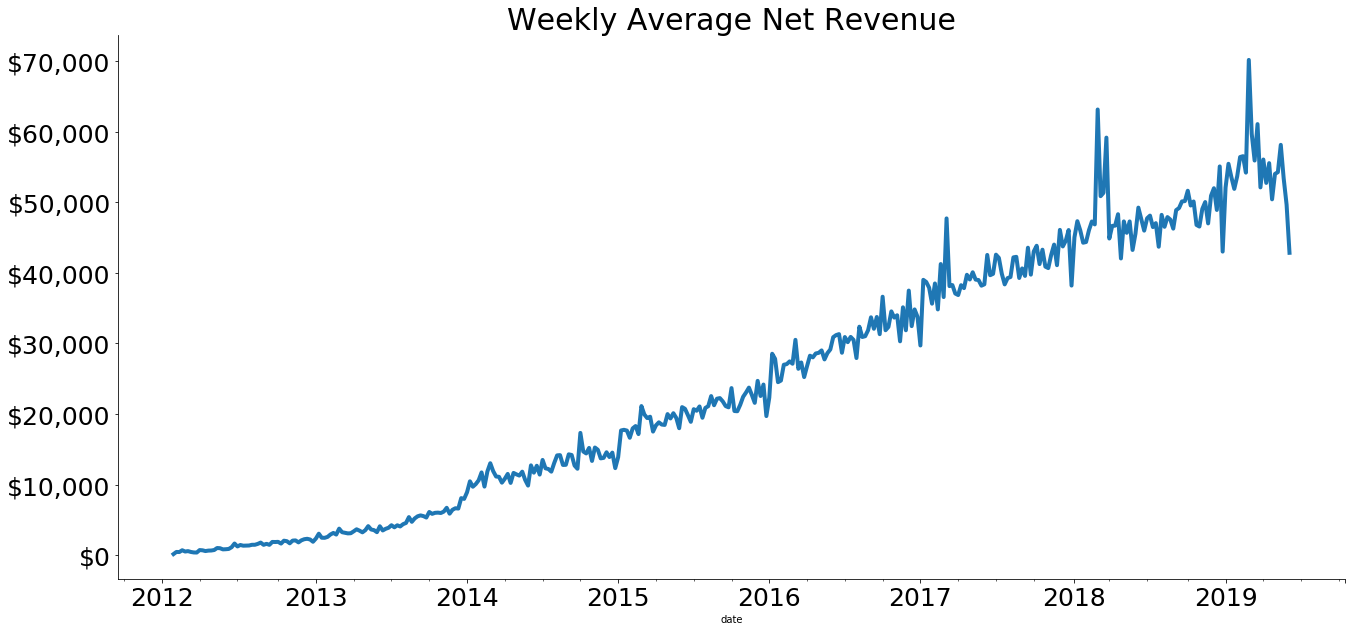

In [16]:
# resample original net revenue data total by week
weekly_net_revenue = df.net_revenue.resample('W').mean()
ax = weekly_net_revenue.plot(figsize=(22,10), fontsize=25, linewidth=4)
plt.title('Weekly Average Net Revenue', fontsize=30)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
sns.despine();

### 2.4.2 Log Transformation

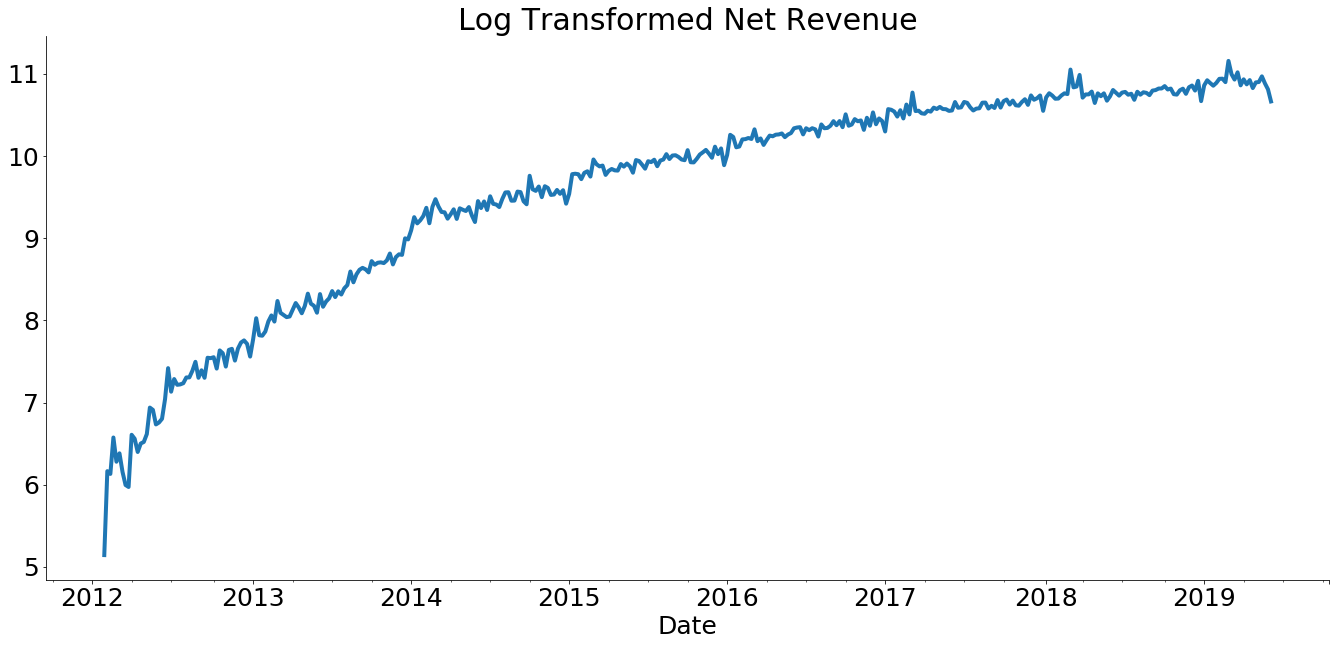

In [17]:
# log transformation of weekly average net revenue and its plot
log_weekly_net_revenue = np.log(weekly_net_revenue)
log_weekly_net_revenue.plot(figsize=(23,10),linewidth=4, fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.title('Log Transformed Net Revenue', fontsize=30)
sns.despine()

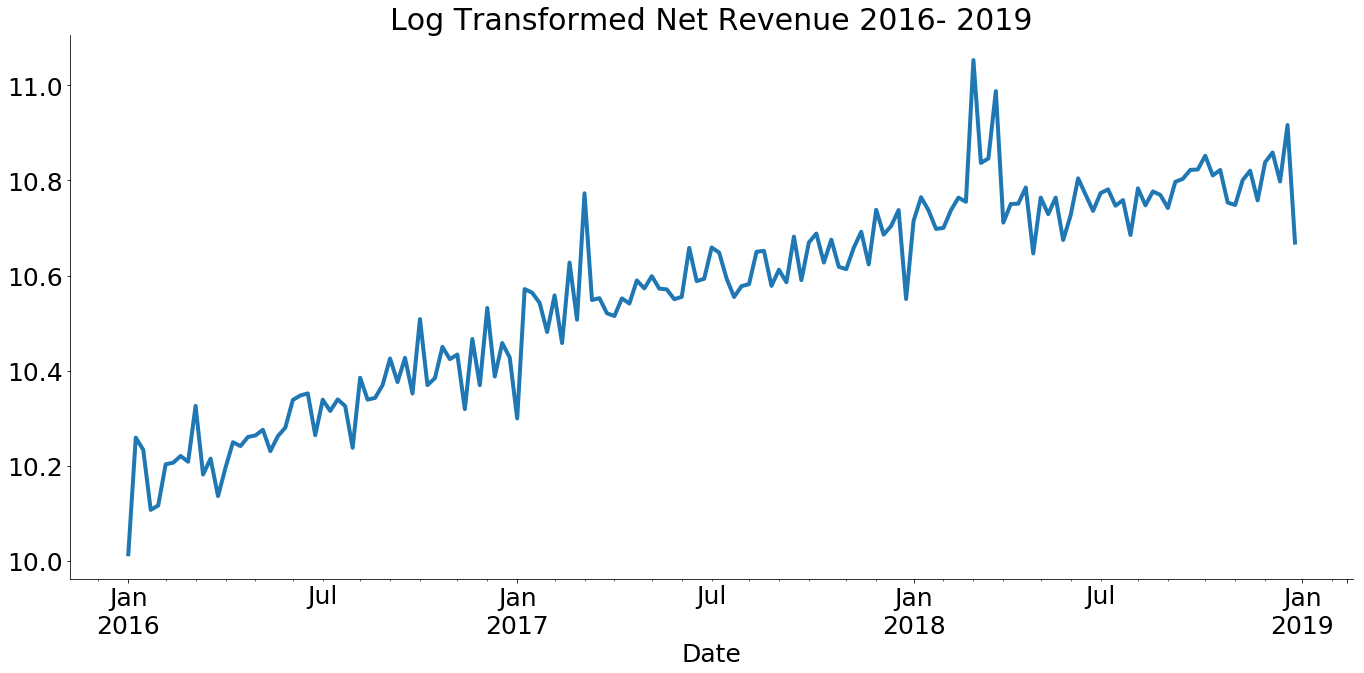

In [18]:
# take a look at 2016-2019 to see if transformed data has smaller spikes
log_weekly_net_revenue['2016-01-01':'2019-01-01'].plot(figsize=(23,10),linewidth=4, fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.title('Log Transformed Net Revenue 2016- 2019', fontsize=30)
sns.despine()
plt.savefig("prj5 log Net Revenue spike.svg");

In [19]:
# check for stationarity
adf_test(log_weekly_net_revenue)

Results of Dickey-Fuller Test:

Test Statistic: -5.7667
P-value: 0.0000
# of Lags Used: 17
# of Obs Used: 367
Critical Value 1%: -3.4483
Critical Value 5%: -2.8694
Critical Value 10%: -2.5710


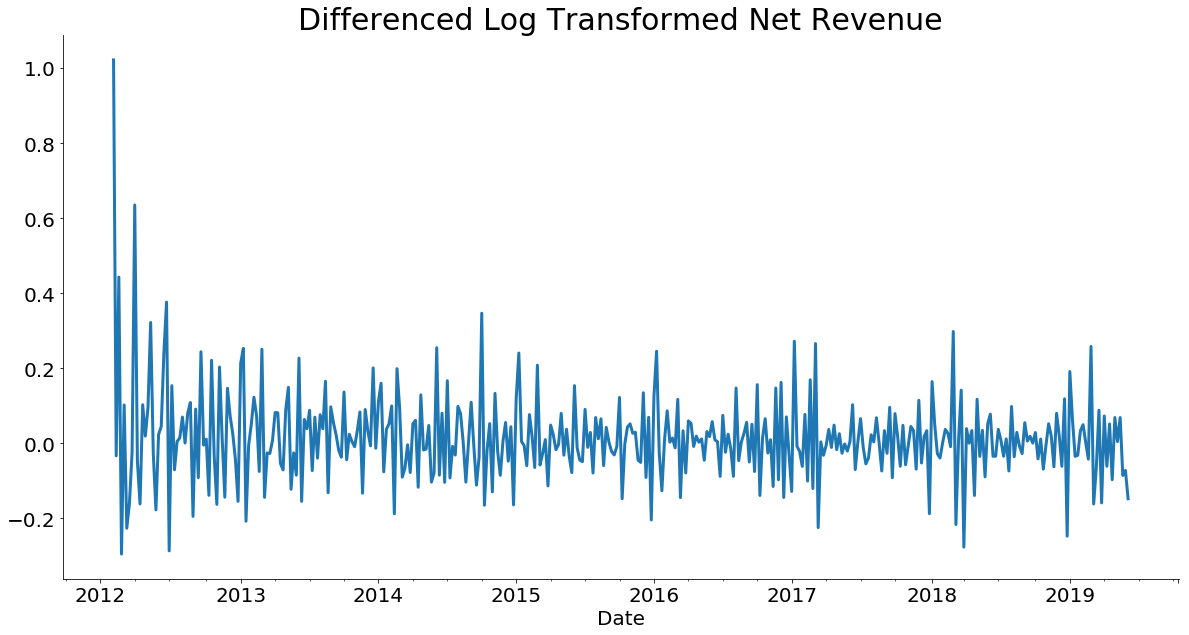

In [20]:
# try differencing to see if it has stationarity
dif_log_weekly_net_revenue = log_weekly_net_revenue.diff(1)
dif_log_weekly_net_revenue.dropna(inplace=True)
dif_log_weekly_net_revenue.plot(figsize=(20,10),linewidth=3, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Differenced Log Transformed Net Revenue', fontsize=30)
sns.despine()
plt.savefig("prj5 diff log Net Revenue.svg");

In [21]:
# check for stationarity for differenced log_weekly_net_revenue
adf_test(dif_log_weekly_net_revenue)

Results of Dickey-Fuller Test:

Test Statistic: -4.8990
P-value: 0.0000
# of Lags Used: 8
# of Obs Used: 375
Critical Value 1%: -3.4479
Critical Value 5%: -2.8693
Critical Value 10%: -2.5709


## 3. Try to Get Some Ideas about Parameters for SARIMA Model
## 3.1 AR(p)

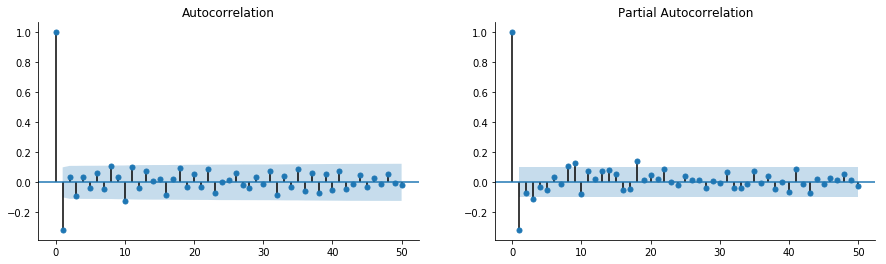

In [22]:
# ACF & PACF plots to decide range for parameters like p and q for modeling
acf_pacf_plot(dif_log_weekly_net_revenue)

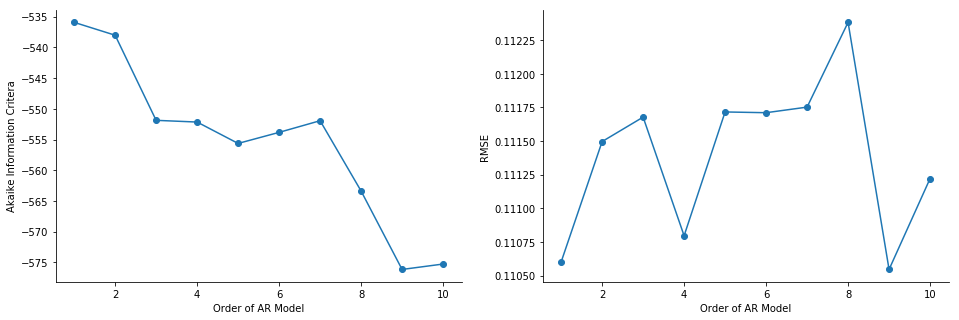

In [23]:
# split dataset
X = dif_log_weekly_net_revenue
train, holdout = X[:len(X)-24], X[len(X)-24:]

# Fit the data to an AR(p) for p = 0, 1, ... , and save the AIC and RMSE
warnings.filterwarnings("ignore")
AIC = []
RMSE = []
for p in range(1,11):
    mod = ARIMA(train, 
                 order=(p,0,0))
    res = mod.fit()
    pred = res.forecast(steps=len(holdout))[0]    
    AIC.append(res.aic)
    rmse = np.sqrt(mean_squared_error(holdout, pred))
    RMSE.append(rmse)

    
# Plot the AIC as a function of p
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
plt.plot(range(1,11), AIC, marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Critera')
sns.despine()

# Plot the RMSE as a function of p
ax2 = fig.add_subplot(122)
plt.plot(range(1,11), RMSE, marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('RMSE')
sns.despine()

**From above plots, p=4 seems the optimal order for AR model.**

In [24]:
# split log_weekly_net_revenue
X1 = log_weekly_net_revenue
train1, holdout1 = X1[:len(X1)-24], X1[len(X1)-24:]

In [25]:
# run AR model
mod1 = SARIMAX(train1,
               order=(4, 0, 0),
               seasonal_order=(0, 0, 0, 0),
               enforce_stationarity=False)

res1 = mod1.fit()

print(res1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5360      0.038     14.217      0.000       0.462       0.610
ar.L2          0.1725      0.055      3.137      0.002       0.065       0.280
ar.L3          0.1267      0.055      2.304      0.021       0.019       0.235
ar.L4          0.1670      0.035      4.749      0.000       0.098       0.236
sigma2         0.0091      0.000     21.654      0.000       0.008       0.010


In [26]:
# Get forecast 24 steps ahead in future
pred_ho1 = res1.forecast(steps=len(holdout))
pred_tr1 = res1.predict(start=0, end=len(train))

In [27]:
# get aic
aic1 = round(res1.aic,4)
print('AIC of the AR model is', aic1)

AIC of the AR model is -656.3695


In [28]:
# create a function to print metrics
def get_metrics(modelname, actual, forecast):
    # get r square
    r_sq1 = round(r2_score(actual, forecast),4)
    print('R^2 of the {} model is'.format(modelname), r_sq1)

    # get rmse
    rmse1 = round(np.sqrt(mean_squared_error(actual, forecast)),4)
    print('RMSE of the {} model is'.format(modelname), rmse1)

    # get mae
    mae1 = round(mean_absolute_error(actual, forecast),4)
    print('MAE of the {} model is'.format(modelname), mae1)

In [29]:
# get metrics on holdout set
get_metrics('AR', holdout1, pred_ho1)

R^2 of the AR model is -3.3067
RMSE of the AR model is 0.2028
MAE of the AR model is 0.1607


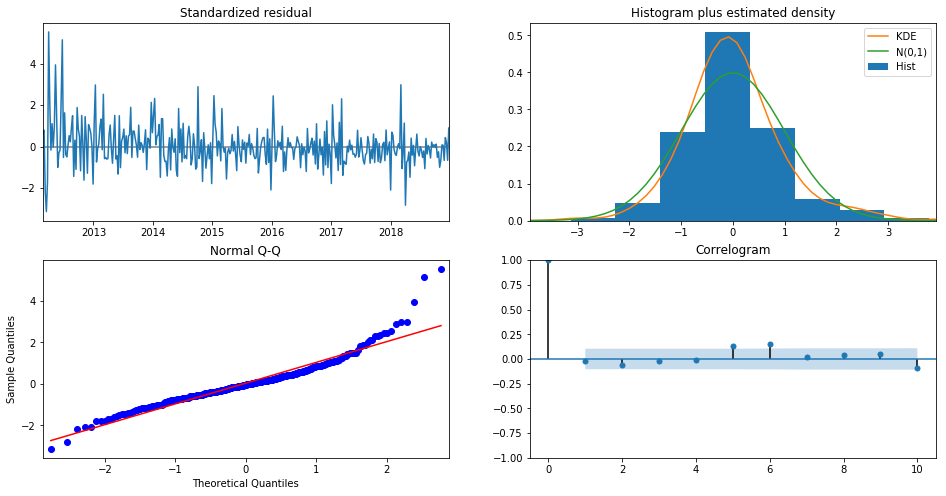

In [30]:
res1.plot_diagnostics(figsize=(16, 8))
plt.show()

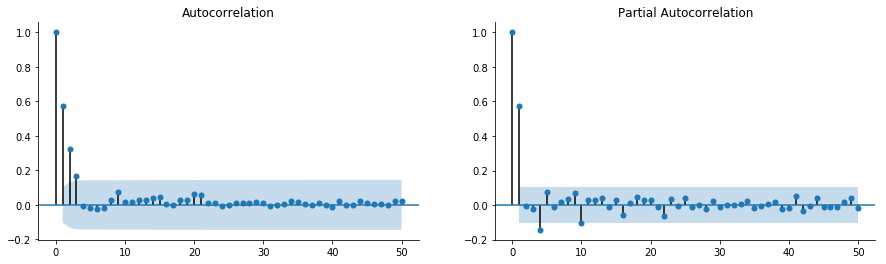

In [31]:
# ACF & PACF Plot of Residuals
acf_pacf_plot(res1.resid)

## 3.2 MA(q)

In [32]:
# from above PACF plot, q=2 seems appropriate for MA model
# run MA model
mod2 = SARIMAX(train1,
               order=(0, 0, 2),
               seasonal_order=(0, 0, 0, 0),
               enforce_stationarity=False)

res2 = mod2.fit()

print(res2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.8610      0.019     95.888      0.000       1.823       1.899
ma.L2          0.9640      0.019     49.512      0.000       0.926       1.002
sigma2         6.8558      1.385      4.949      0.000       4.141       9.571


In [33]:
# Get forecast 24 steps ahead in future
pred_ho2 = res2.forecast(steps=len(holdout1))
pred_tr2 = res2.predict(start=0, end=len(train1))

In [34]:
# get aic
aic2 = round(res2.aic,4)
print('AIC of the MA model is', aic2)

AIC of the MA model is 1718.7273


In [35]:
# get metics on holdout set
get_metrics('MA', holdout1, pred_ho2)

R^2 of the MA model is -11655.5711
RMSE of the MA model is 10.5532
MAE of the MA model is 10.3694


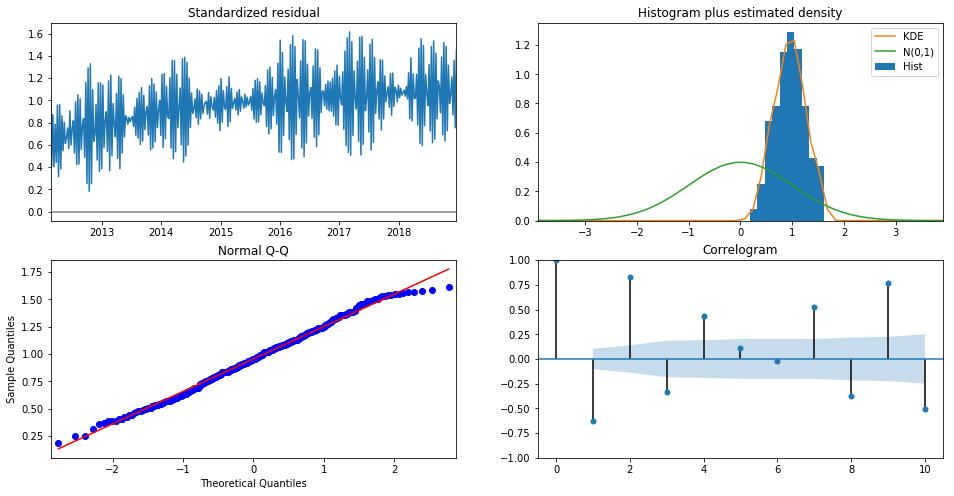

In [36]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

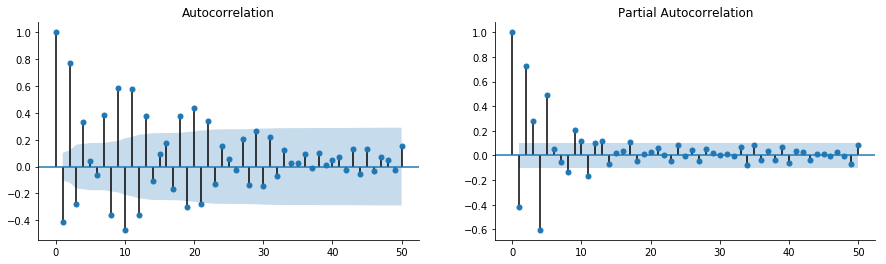

In [37]:
# ACF & PACF Plot of Residuals
acf_pacf_plot(res2.resid)

## 3.3 ARMA(p, q)

In [38]:
# run ARMA model
# use the optimal p from above AR model and q from above MA model
mod3 = SARIMAX(train1,
               order=(4, 0, 2),
               seasonal_order=(0, 0, 0, 0),
               enforce_stationarity=False)

res3 = mod3.fit()

print(res3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3319      0.101      3.296      0.001       0.135       0.529
ar.L2          0.5786      0.103      5.619      0.000       0.377       0.780
ar.L3         -0.0209      0.101     -0.206      0.837      -0.219       0.178
ar.L4          0.1125      0.060      1.873      0.061      -0.005       0.230
ma.L1          0.2257      0.105      2.157      0.031       0.021       0.431
ma.L2         -0.3499      0.102     -3.413      0.001      -0.551      -0.149
sigma2         0.0090      0.000     19.235      0.000       0.008       0.010


In [39]:
# Get forecast 24 steps ahead in future
pred_ho3 = res3.forecast(steps=len(holdout1))
pred_tr3 = res3.predict(start=0, end=len(train1))

In [40]:
# get aic
aic3 = round(res3.aic,4)
print('AIC of the AR model is', aic3)

AIC of the AR model is -654.4591


In [41]:
# get metics on holdout set
get_metrics('ARMA', holdout1, pred_ho3)

R^2 of the ARMA model is -3.2199
RMSE of the ARMA model is 0.2008
MAE of the ARMA model is 0.1581


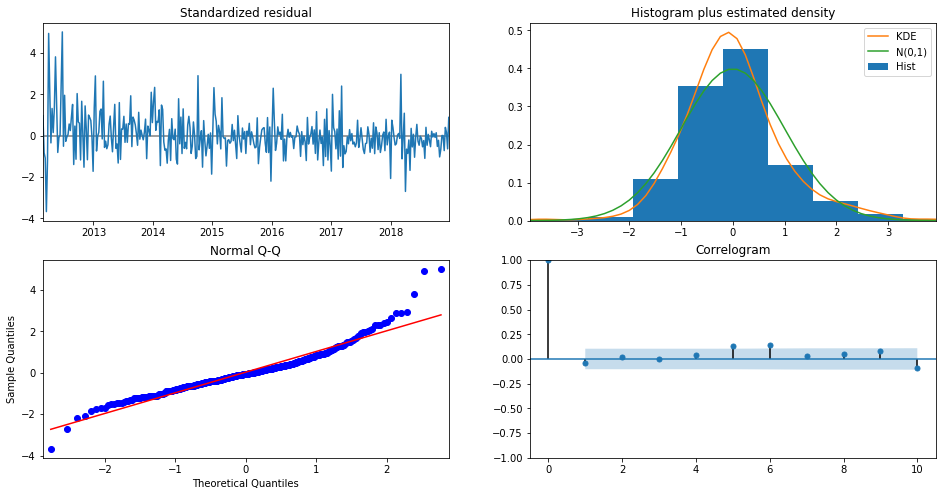

In [42]:
res3.plot_diagnostics(figsize=(16, 8))
plt.show()

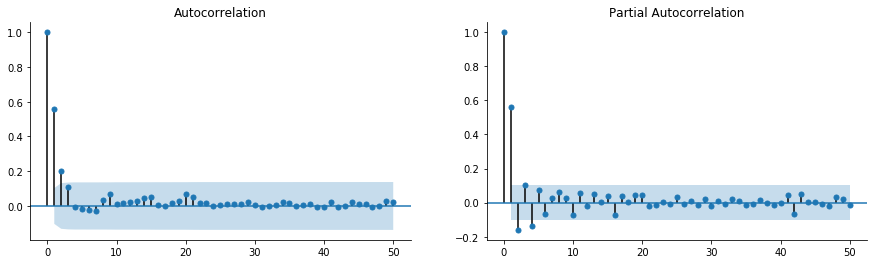

In [43]:
# ACF & PACF Plot of Residuals
acf_pacf_plot(res3.resid)

## 3.4 ARIMR(p, d, q)

In [44]:
# run ARIMA model
# use p and q from above ARMA model and take first differencing
mod4 = SARIMAX(train1,
               order=(3, 1, 2),
               seasonal_order=(0, 0, 0, 0))

res4 = mod4.fit()

print(res4.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1404      0.074     15.496      0.000       0.996       1.285
ar.L2         -0.3103      0.052     -6.005      0.000      -0.412      -0.209
ar.L3         -0.0998      0.040     -2.487      0.013      -0.178      -0.021
ma.L1         -1.6553      0.075    -22.000      0.000      -1.803      -1.508
ma.L2          0.8341      0.054     15.551      0.000       0.729       0.939
sigma2         0.0124      0.000     29.546      0.000       0.012       0.013


In [48]:
# out of sample prediction
forecast_holdout4 = res4.get_forecast(steps=len(holdout1))
pred_ho4 = forecast_holdout4.predicted_mean
pred_future4 = res4.forecast(steps=len(holdout1)+12)

# in sample prediction
pred_tr4 = res4.predict(start=pd.to_datetime('2012-01-29'), end=pd.to_datetime('2018-12-30'),typ='levels')
pred_train4 = res4.get_prediction(start=pd.to_datetime('2012-01-29'), end=pd.to_datetime('2018-12-30'),typ='levels')

# Get confidence intervals of forecasts
forecast_holdout4_ci = forecast_holdout4.conf_int()
pred_train4_ci = pred_train4.conf_int()

In [49]:
# get aic
aic4 = round(res4.aic,4)
print('AIC of the ARIMA model is', aic4)

AIC of the ARIMA model is -545.2624


In [50]:
# get metics on holdout set
get_metrics('ARIMA', holdout1, pred_ho4)

R^2 of the ARIMA model is 0.1006
RMSE of the ARIMA model is 0.0927
MAE of the ARIMA model is 0.0624


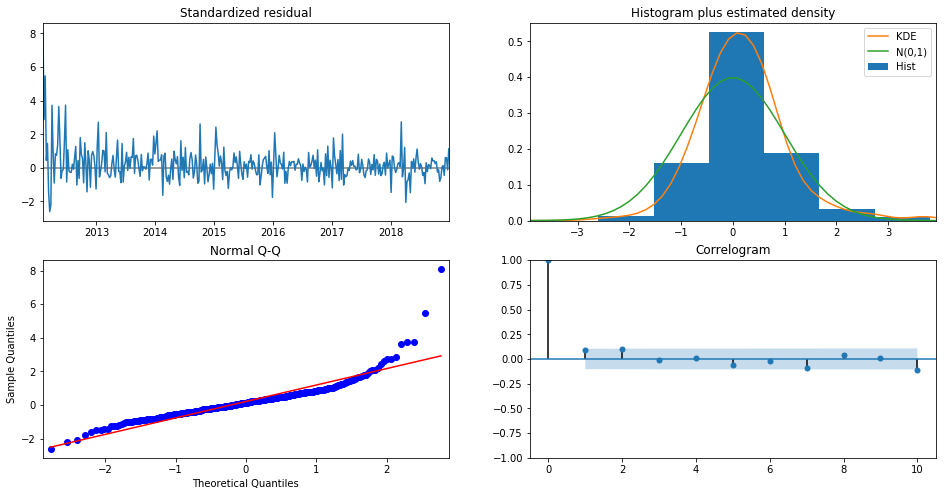

In [51]:
res4.plot_diagnostics(figsize=(16, 8))
plt.show()

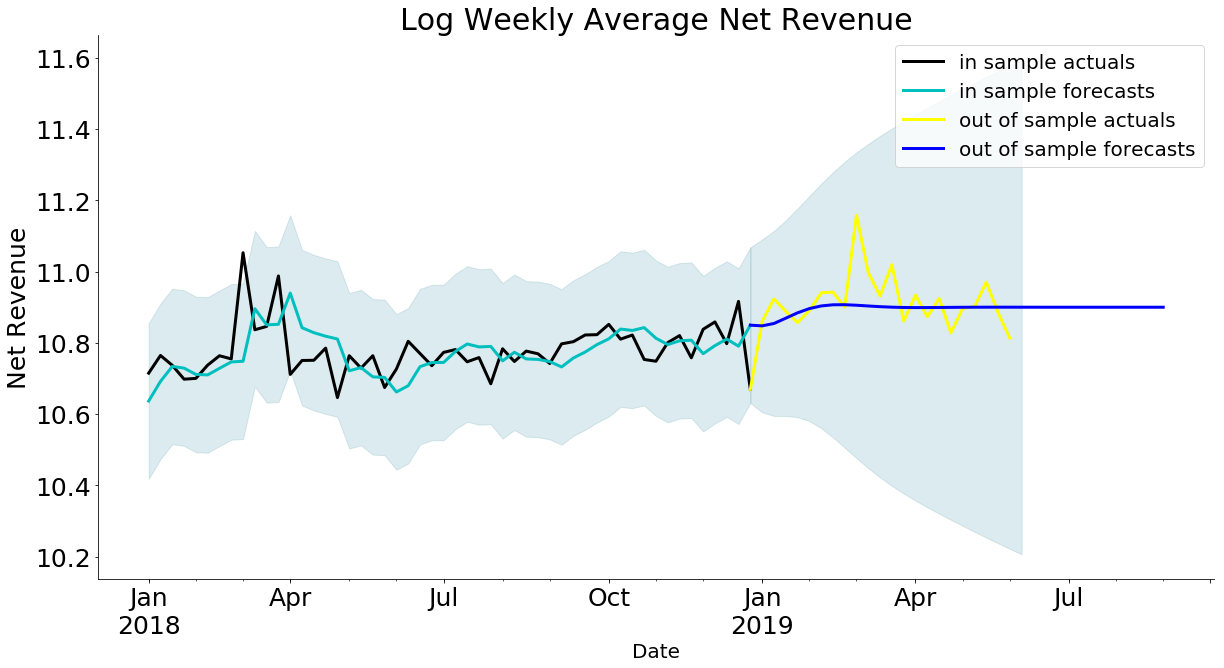

In [52]:
# plot of in sample actuals and forecasts
ax = X1.loc['2018-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(20, 10), linewidth=3, color='black', fontsize=25)
pred_tr4.loc['2018-01-01':'2018-12-30'].plot(label='in sample forecasts', linewidth=3, color='c')

# plot of out of sample actuals and forecasts
X1.loc['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', linewidth=3, color='yellow')
pred_future4.plot(label='out of sample forecasts', linewidth=3, color='blue')

ax.fill_between(forecast_holdout4_ci.index,
                forecast_holdout4_ci.iloc[:, 0],
                forecast_holdout4_ci.iloc[:, 1], color='#539caf', alpha=.2)
ax.fill_between(pred_train4_ci.loc['2018-01-01':'2018-12-30'].index,
                pred_train4_ci.loc['2018-01-01':'2018-12-30'].iloc[:, 0],
                pred_train4_ci.loc['2018-01-01':'2018-12-30'].iloc[:, 1], color='#539caf', alpha=.2)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Net Revenue', fontsize=25)
plt.legend(fontsize=20)
plt.title('Log Weekly Average Net Revenue', fontsize=30)
sns.despine()

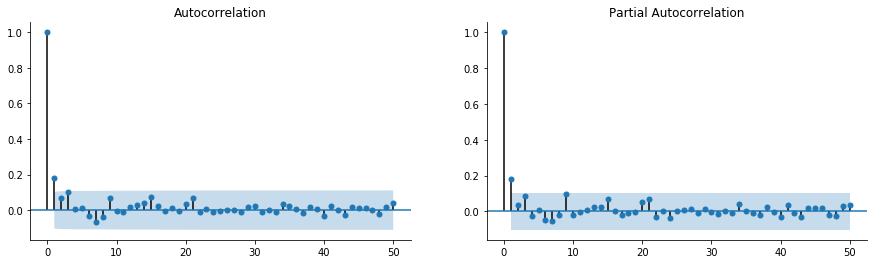

In [53]:
# ACF & PACF Plot of Residuals
acf_pacf_plot(res4.resid)

# 4. SARIMA Model

In [49]:
# based on above exploration, set appropriate range for parameters of SARIMAX model
p = list(range(0, 5))
d = list(range(0, 2))
q = list(range(0, 3))
order_pdq = [(4, 1, 2), (4, 1, 1),(3, 1, 2), (3, 1, 1),(2, 1, 2), (2, 1, 1)]
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
param_trend = ['n','c','t','ct']

In [ ]:
# find optimal parameters
warnings.filterwarnings("ignore")

lowest_aic = 0
lowest_param = 0
lowest_param_seasonal = 0
lowest_param_trend = 0

for param in order_pdq:
    for param_seasonal in seasonal_pdq:
        for p_trend in param_trend:
            try:
                mod = SARIMAX(train1,
                              order=param,
                              seasonal_order=param_seasonal,
                              trend= p_trend,
                              enforce_stationarity=False,
                              enforce_invertibility=False)

                results = mod.fit()
                # Store results
                current_aic = results.aic
                # Set baseline for aic
                if (lowest_aic == 0):
                    lowest_aic = results.aic
                # Compare results
                if (current_aic <= lowest_aic):
                    lowest_aic = current_aic
                    lowest_param = param
                    lowest_param_seasonal = param_seasonal
                    lowest_param_trend = p_trend
                print('SARIMA [{}, {}, {}]  AIC: {}'.format(param, param_seasonal, p_trend, results.aic))
                print('optimal SARIMA [{}, {}, {}]  AIC: {}'.format(lowest_param, lowest_param_seasonal, lowest_param_trend, lowest_aic))
            except:
                continue

**The above output suggests that SARIMA(3, 1, 1)x(1, 0, 1, 52)xn yields the lowest AIC value of -759. Therefore we should consider this to be optimal option.**

In [54]:
# run SARIMA model with the optimal parameters
mod5 = SARIMAX(train1,
               order=(3, 1, 1),
               seasonal_order=(1, 0, 1, 52),
               enforce_stationarity=False,
               enforce_invertibility=False)

res5 = mod5.fit()

print(res5.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4532      0.413     -1.097      0.273      -1.263       0.357
ar.L2         -0.1903      0.253     -0.753      0.452      -0.686       0.305
ar.L3         -0.0649      0.115     -0.565      0.572      -0.290       0.160
ma.L1         -0.1776      0.406     -0.438      0.662      -0.973       0.617
ar.S.L52       0.2184      0.038      5.815      0.000       0.145       0.292
ma.S.L52       0.3117      0.072      4.352      0.000       0.171       0.452
sigma2         0.0046      0.000     14.013      0.000       0.004       0.005


In [55]:
# out of sample prediction
forecast_holdout5 = res5.get_forecast(steps=len(holdout1))
pred_ho5 = forecast_holdout5.predicted_mean
pred_future5 = res5.forecast(steps=len(holdout1)+12)

# in sample prediction
pred_tr5 = res5.predict(start=pd.to_datetime('2012-01-29'), end=pd.to_datetime('2018-12-30'),typ='levels')
pred_train5 = res5.get_prediction(start=pd.to_datetime('2012-01-29'), end=pd.to_datetime('2018-12-30'),typ='levels')

# Get confidence intervals of forecasts
forecast_holdout5_ci = forecast_holdout5.conf_int()
pred_train5_ci = pred_train5.conf_int()

In [56]:
# get aic
aic5 = round(res5.aic,4)
print('AIC of the SARIMA model is', aic5)

AIC of the SARIMA model is -759.3696


In [57]:
# get metics on holdout set
get_metrics('ARIMA', holdout1, pred_ho5)

R^2 of the ARIMA model is 0.417
RMSE of the ARIMA model is 0.0746
MAE of the ARIMA model is 0.0537


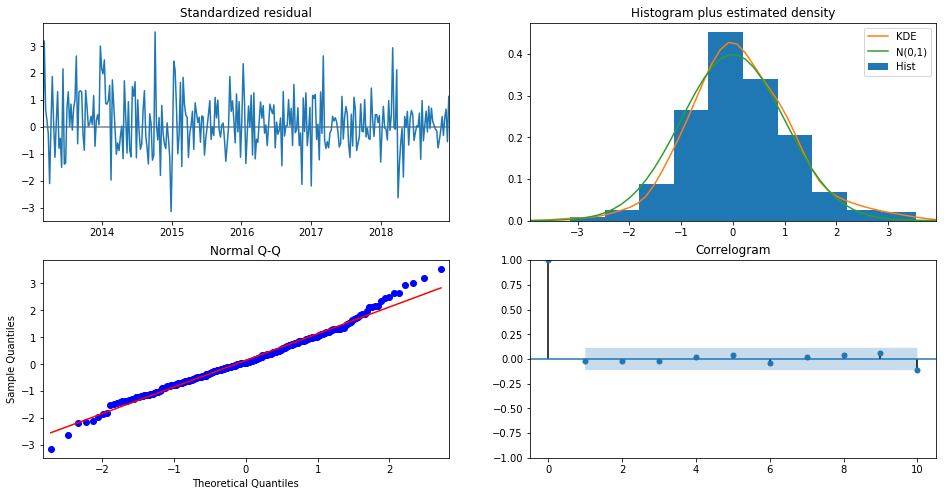

In [58]:
res5.plot_diagnostics(figsize=(16, 8))
plt.show()

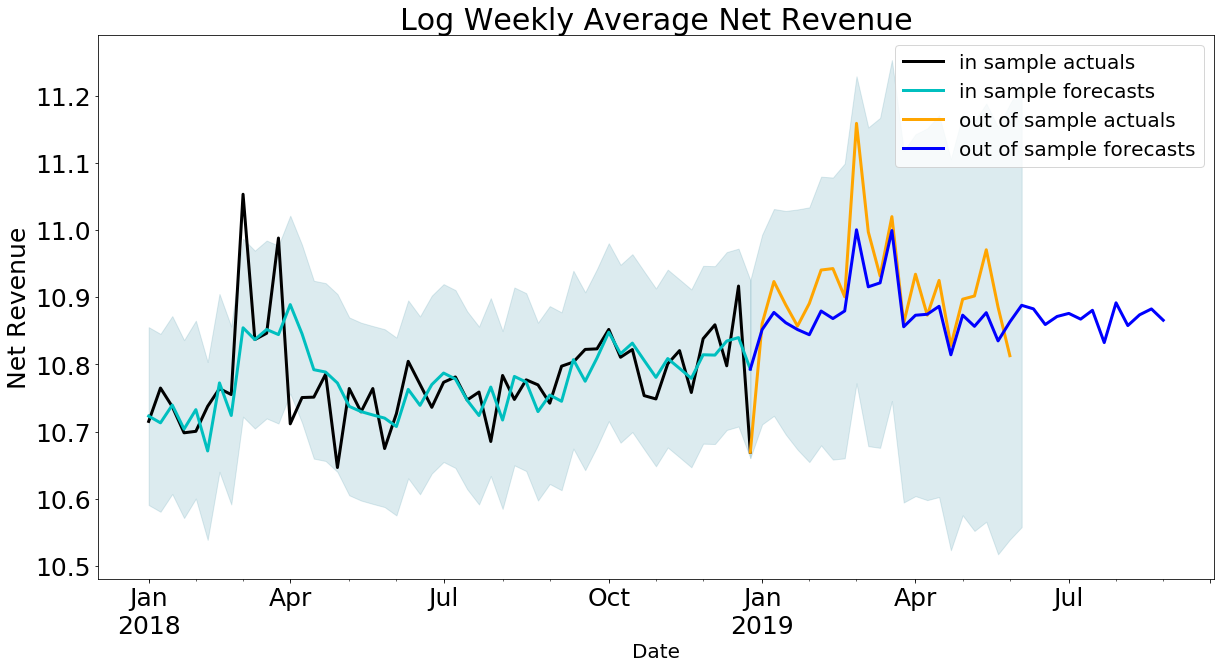

In [59]:
# plot of in sample actuals and forecasts
ax = X1.loc['2018-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(20, 10), linewidth=3, color='black', fontsize=25)
pred_tr5.loc['2018-01-01':'2018-12-30'].plot(label='in sample forecasts', linewidth=3, color='c')

# plot of out of sample actuals and forecasts
X1.loc['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', linewidth=3, color='orange')
pred_future5.plot(label='out of sample forecasts', linewidth=3, color='blue')

ax.fill_between(forecast_holdout5_ci.index,
                forecast_holdout5_ci.iloc[:, 0],
                forecast_holdout5_ci.iloc[:, 1], color='#539caf', alpha=.2)
ax.fill_between(pred_train5_ci.loc['2018-01-01':'2018-12-30'].index,
                pred_train5_ci.loc['2018-01-01':'2018-12-30'].iloc[:, 0],
                pred_train5_ci.loc['2018-01-01':'2018-12-30'].iloc[:, 1], color='#539caf', alpha=.2)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Net Revenue', fontsize=25)
plt.legend(fontsize=20)
plt.title('Log Weekly Average Net Revenue', fontsize=30)
plt.show()

In [60]:
# convert logged data back to weekly average level by taking np.exp()
pred_future5_exp = np.exp(pred_future5)
pred_tr5_exp = np.exp(pred_tr5)

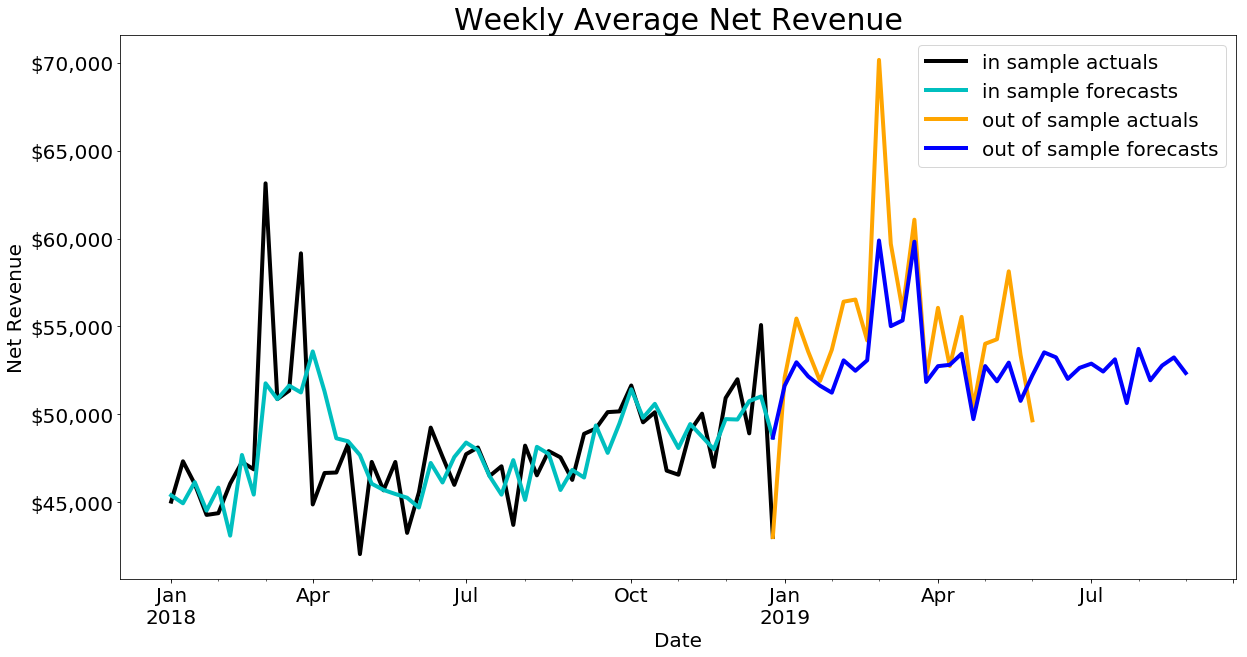

In [61]:
# plot of in sample actuals and forecasts
ax = weekly_net_revenue.loc['2018-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(20, 10), linewidth=4, color='black', fontsize=20)
pred_tr5_exp.loc['2018-01-01':'2018-12-30'].plot(label='in sample forecasts', linewidth=4, color='c')

# plot of out of sample actuals and forecasts
weekly_net_revenue['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', linewidth=4, color='orange')
pred_future5_exp.plot(label='out of sample forecasts', linewidth=4, color='blue')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Net Revenue', fontsize=20)
plt.legend(fontsize=20)
plt.title('Weekly Average Net Revenue', fontsize=30)
plt.show()

In [62]:
# convert weekly average data to weekly total data level
pred_future5_exp_t = pred_future5_exp*7
pred_tr5_exp_t = pred_tr5_exp*7
total_weekly_net_revenue = weekly_net_revenue*7

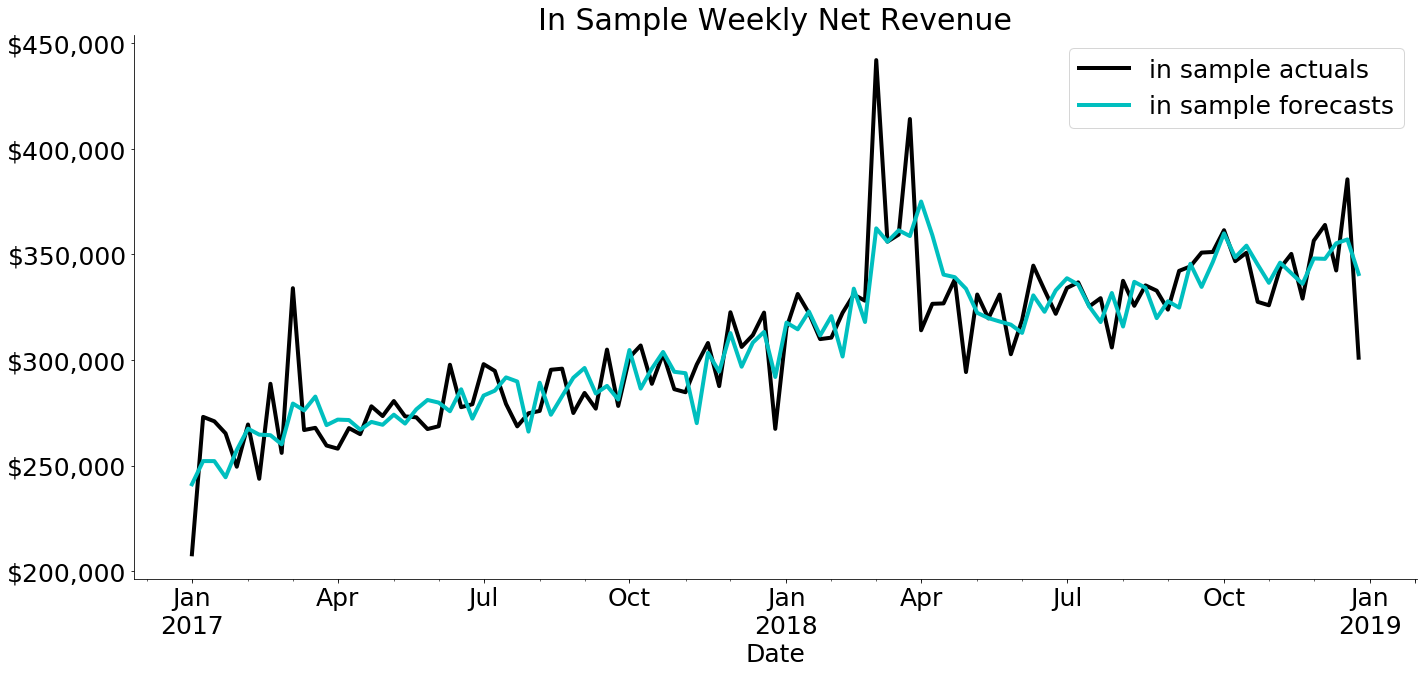

In [63]:
# take a look at 2017 and 2018
# in sample predictions
ax = total_weekly_net_revenue.loc['2017-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(23, 10), linewidth=4, color='black', fontsize=25)
pred_tr5_exp_t.loc['2017-01-01':'2018-12-30'].plot(label='in sample forecasts', linewidth=4, color='c')
ax.set_xlabel('Date', fontsize=25)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.legend(fontsize=25, loc='best')
plt.title('In Sample Weekly Net Revenue', fontsize=30)
sns.despine()
plt.savefig("prj5 Weekly Total Net Revenue is.svg")

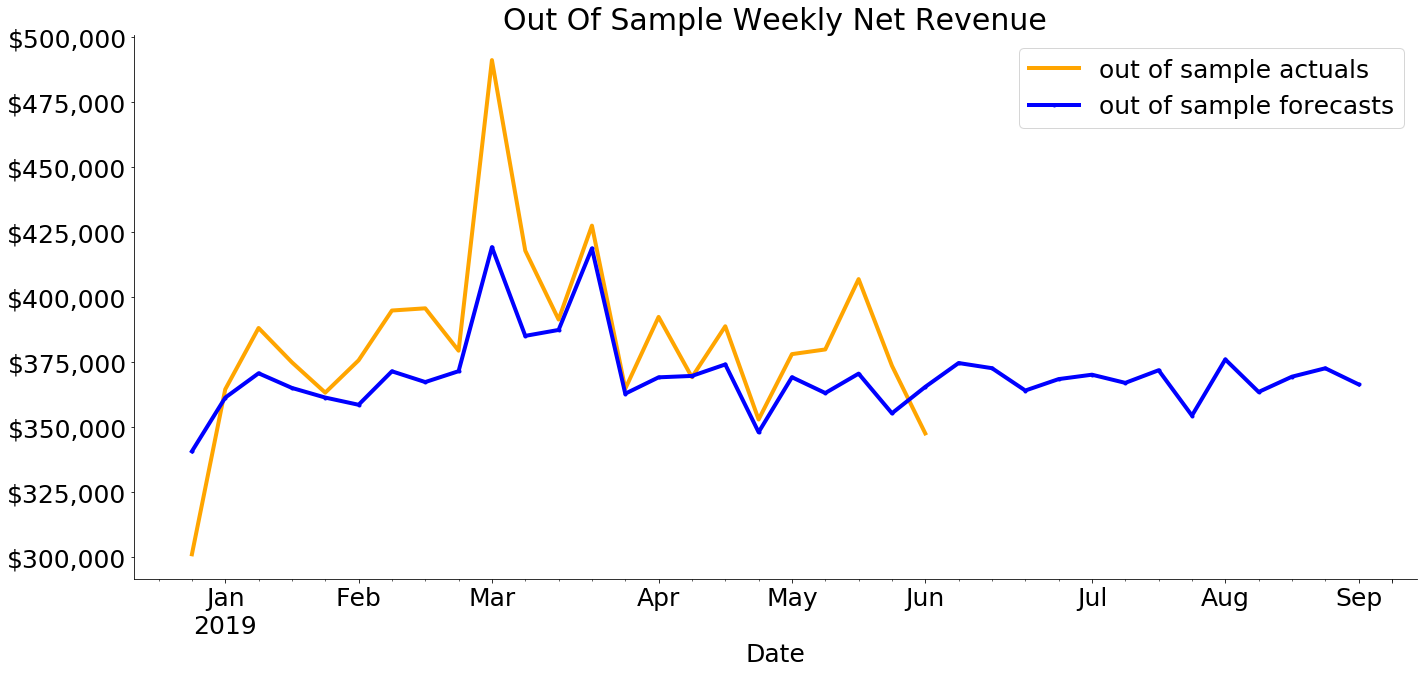

In [64]:
# out of sample predictions
ax = total_weekly_net_revenue['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', figsize=(23, 10), linewidth=4, color='orange', fontsize=25)
pred_future5_exp_t.plot(label='out of sample forecasts', linewidth=4, color='blue', style='.-')

ax.set_xlabel('Date', fontsize=25)
#ax.set_ylabel('Net Revenue', fontsize=20)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.legend(fontsize=25, loc='best')
plt.title('Out Of Sample Weekly Net Revenue', fontsize=30)
sns.despine()
plt.savefig("prj5 Weekly Total Net Revenue oos.svg")

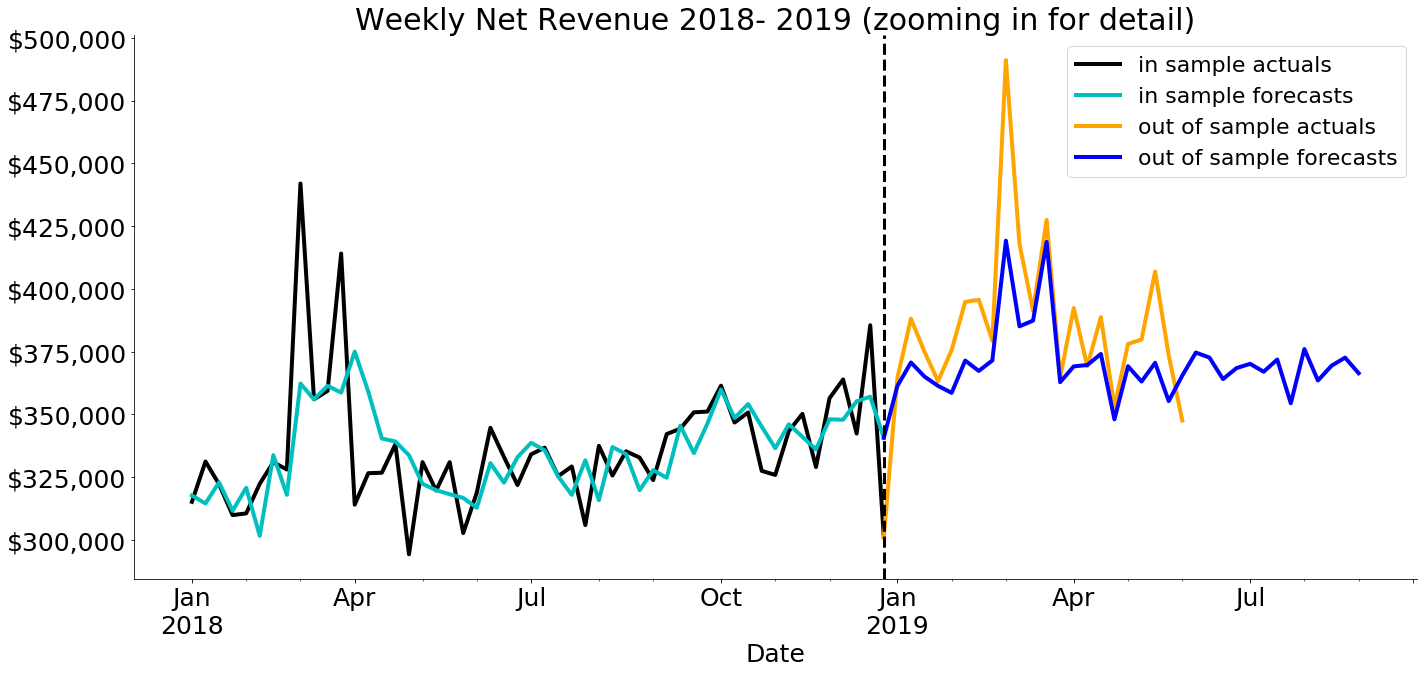

In [65]:
# zooming in 2018 & 2019 for detail
# plot of in sample actuals and forecasts
ax = total_weekly_net_revenue.loc['2018-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(23, 10), linewidth=4, color='black', fontsize=25)
pred_tr5_exp_t.loc['2018-01-01':'2018-12-30'].plot(label='in sample forecasts', linewidth=4, color='c')

# plot of out of sample actuals and forecasts
total_weekly_net_revenue['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', linewidth=4, color='orange')
pred_future5_exp_t.plot(label='out of sample forecasts', linewidth=4, color='blue')

ax.set_xlabel('Date', fontsize=25)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend(fontsize=22, loc='best')
plt.title('Weekly Net Revenue 2018- 2019 (zooming in for detail)', fontsize=30)
plt.axvline(x='2018-12-30', linestyle='--', color='black', linewidth=3)
sns.despine()
plt.savefig("prj5 Weekly Total Net Revenue detail.svg")

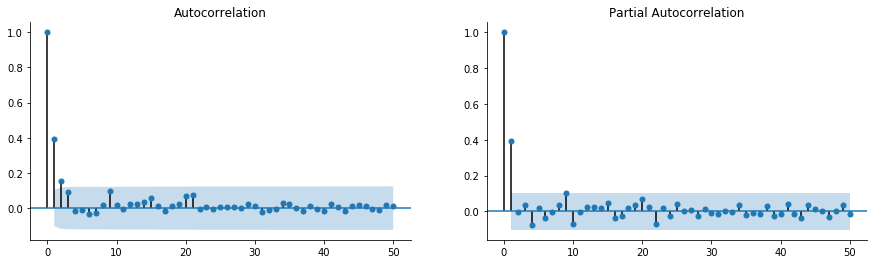

In [66]:
# ACF & PACF Plot of Residuals
acf_pacf_plot(res5.resid)

# 5. SARIMAX Model with Coupons as External Variable

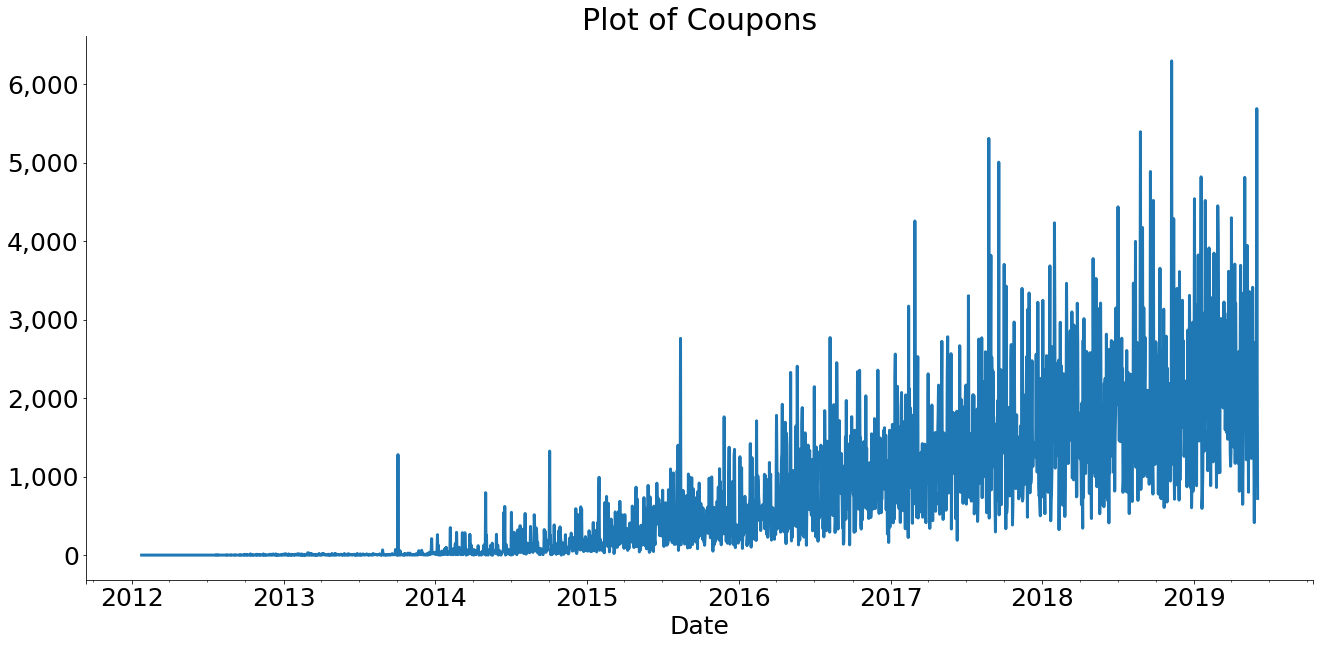

In [67]:
# plot of coupons
ax = df.coupons.plot(linewidth=3, figsize=(22, 10), fontsize=25)
plt.title('Plot of Coupons', fontsize=30)
plt.xlabel('Date', fontsize=25)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
sns.despine()

In [68]:
# take weekly average of coupons
weekly_coupons = df.coupons.resample('W').mean()

In [69]:
# split weekly_coupons into train and holdout sets and convert them into data frames
exog_train = weekly_coupons[:len(X1)-24]
exog_test = weekly_coupons[len(X1)-24:]
exog_train = pd.DataFrame(exog_train)
exog_test = pd.DataFrame(exog_test)

In [70]:
# run SARIMAX model with coupons as exog variable
mod6 = SARIMAX(train1,
               order=(3, 1, 1),
               seasonal_order=(1, 0, 1, 52),
               exog = exog_train,
               enforce_stationarity=False,
               enforce_invertibility=False)

res6 = mod6.fit()

print(res6.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
coupons     3.831e-05   4.12e-05      0.930      0.352   -4.24e-05       0.000
ar.L1         -0.1781      0.448     -0.397      0.691      -1.056       0.700
ar.L2         -0.1645      0.198     -0.830      0.407      -0.553       0.224
ar.L3         -0.1179      0.141     -0.834      0.405      -0.395       0.159
ma.L1         -0.2472      0.448     -0.551      0.581      -1.126       0.631
ar.S.L52       0.4920      0.051      9.637      0.000       0.392       0.592
ma.S.L52      -0.1833      0.117     -1.569      0.117      -0.412       0.046
sigma2         0.0093      0.001      8.804      0.000       0.007       0.011


In [94]:
# out of sample prediction
forecast_holdout6 = res6.get_forecast(steps=len(holdout1), exog=exog_test)
pred_ho6 = forecast_holdout6.predicted_mean

# in sample prediction
pred_train6 = res6.get_prediction(typ='levels', exog=exog_train)
pred_t6 = pred_train6.predicted_mean

# confidence intervals of forecasts
forecast_holdout6_ci = forecast_holdout6.conf_int()
pred_train6_ci = pred_train6.conf_int()

In [95]:
# get aic
aic6 = round(res6.aic,4)
print('AIC of the SARIMA model is', aic6)

AIC of the SARIMA model is -677.6677


In [96]:
# get metics on holdout set
get_metrics('SARIMAX', holdout1, pred_ho6)

R^2 of the SARIMAX model is 0.5206
RMSE of the SARIMAX model is 0.0677
MAE of the SARIMAX model is 0.0481


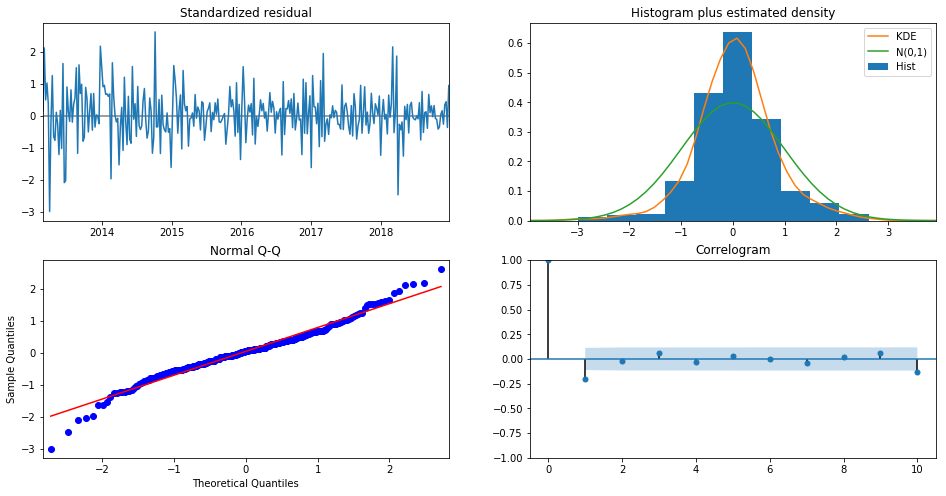

In [97]:
res6.plot_diagnostics(figsize=(16, 8))
plt.show()

In [98]:
# convert logged data back to weekly average level
pred_tr6_exp = np.exp(pred_t6)
forecast_ho6_exp = np.exp(pred_ho6)

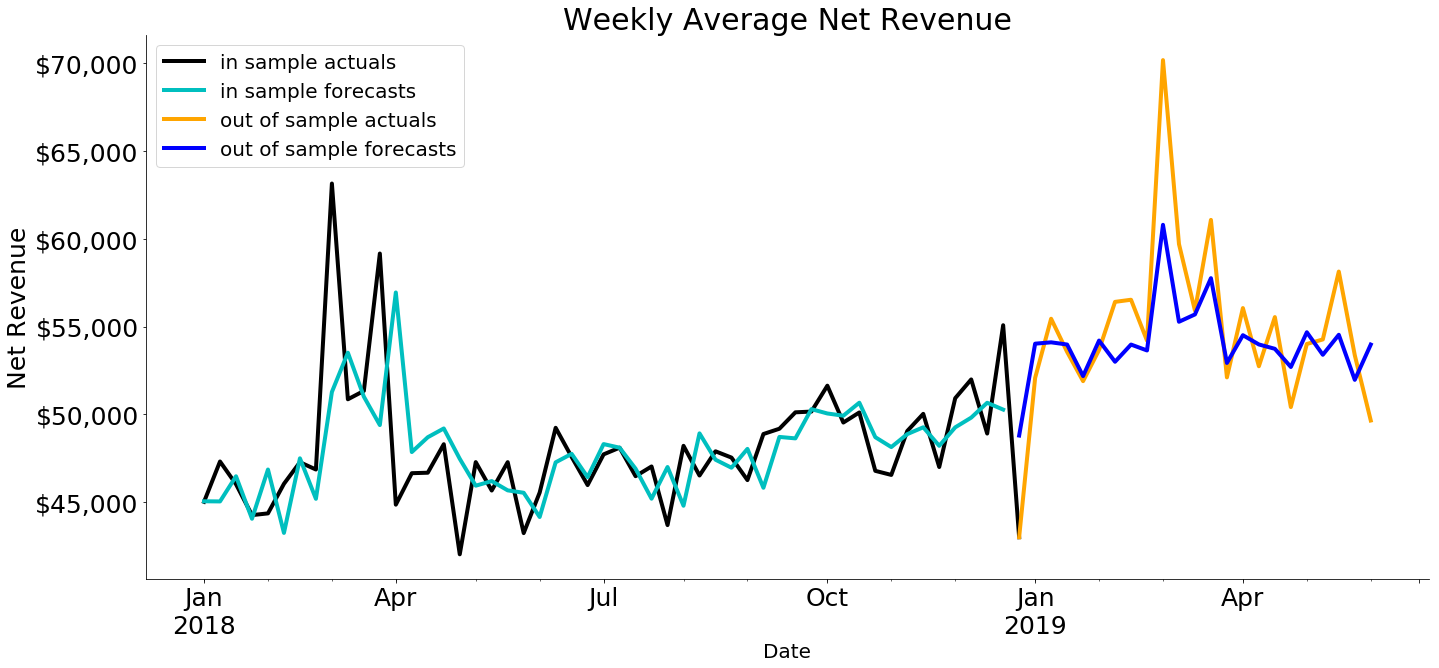

In [100]:
# plot in sample actuals and forecasts
ax = weekly_net_revenue['2018-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(23, 10), linewidth=4, color='black', fontsize=25)
pred_tr6_exp.loc['2018-01-01':].plot(label='in sample forecasts', linewidth=4, color='c')

# plot out of sample actuals and forecasts
weekly_net_revenue['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', linewidth=4, color='orange')
forecast_ho6_exp[:'2019-06-02'].plot(label='out of sample forecasts', linewidth=4, color='blue')

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Net Revenue', fontsize=25)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.legend(fontsize=20)
plt.title('Weekly Average Net Revenue', fontsize=30)
sns.despine()

In [77]:
# convert weekly avg data back to weekly total level
pred_tr6_exp_t = pred_tr6_exp*7
forecast_ho6_exp_t = forecast_ho6_exp*7

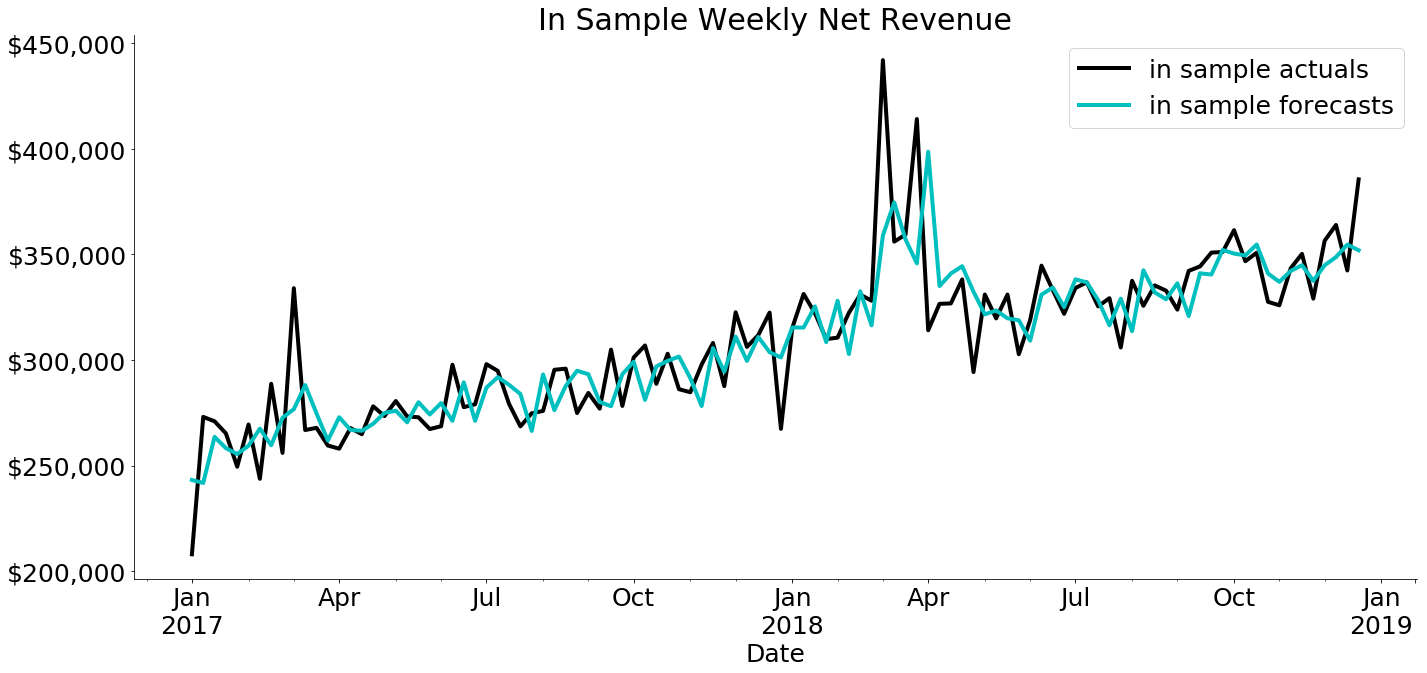

In [90]:
# take a look at 2017 and 2018
# in sample predictions
ax = total_weekly_net_revenue['2017-01-01':'2018-12-23'].plot(label='in sample actuals', figsize=(23, 10), linewidth=4, color='black', fontsize=25)
pred_tr6_exp_t.loc['2017-01-01':].plot(label='in sample forecasts', linewidth=4, color='c')
ax.set_xlabel('Date', fontsize=25)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.legend(fontsize=25, loc='best')
plt.title('In Sample Weekly Net Revenue', fontsize=30)
sns.despine()
# plt.savefig("prj5 Weekly Total Net Revenue is.svg")

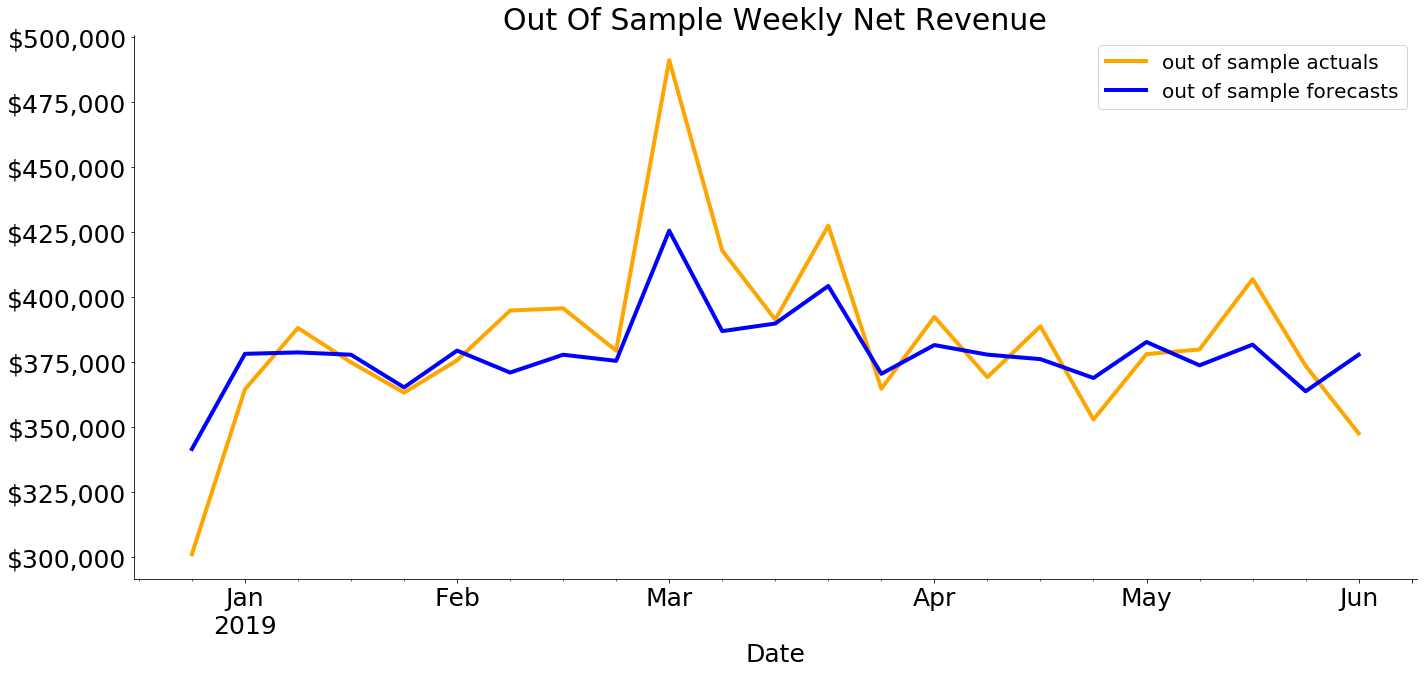

In [88]:
# out of sample predictions
ax = total_weekly_net_revenue['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', figsize=(23, 10), linewidth=4, color='orange', fontsize=25)
forecast_ho6_exp_t[:'2019-06-02'].plot(label='out of sample forecasts', linewidth=4, color='blue')
ax.set_xlabel('Date', fontsize=25)
#ax.set_ylabel('Net Revenue', fontsize=20)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.legend(fontsize=20, loc='best')
plt.title('Out Of Sample Weekly Net Revenue', fontsize=30)
sns.despine()
# plt.savefig("prj5 Weekly Total Net Revenue oos.svg")

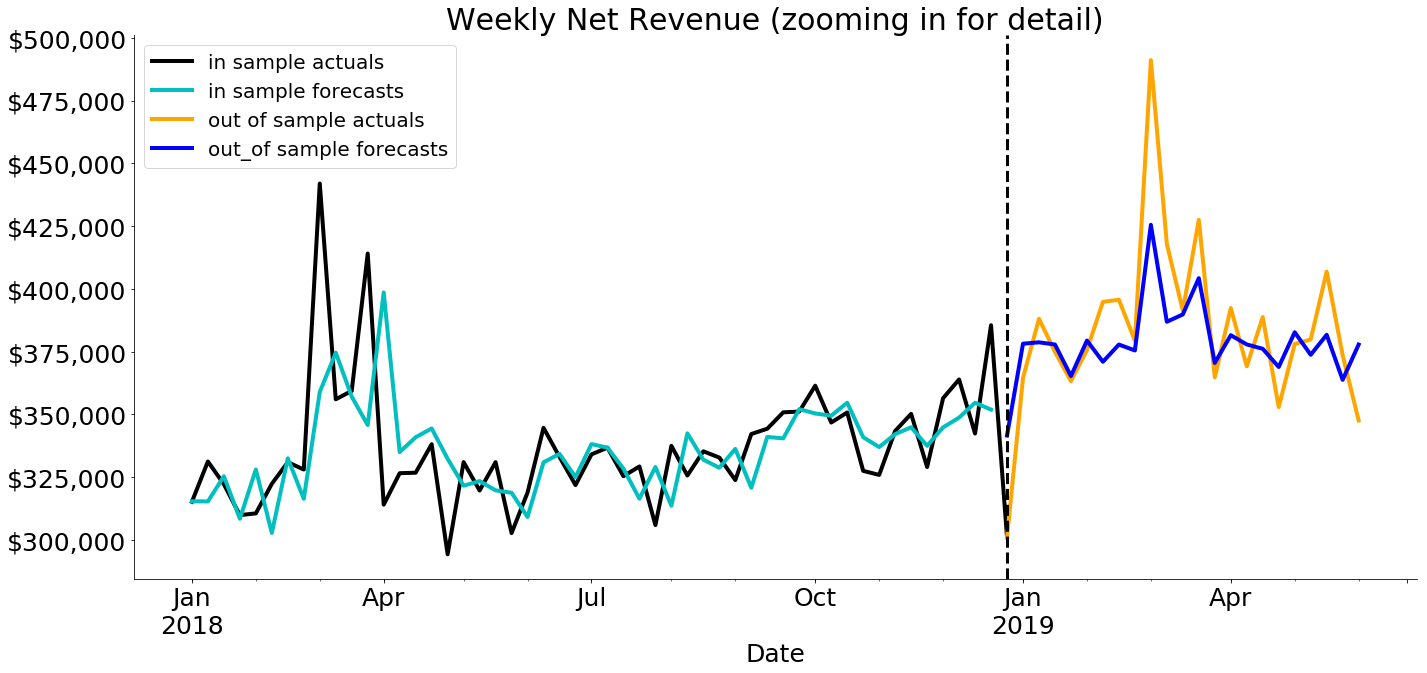

In [87]:
# zooming in 2018 & 2019 for detail

# plot of in sample actuals and forecasts
ax = total_weekly_net_revenue['2018-01-01':'2018-12-30'].plot(label='in sample actuals', figsize=(23, 10), linewidth=4, color='black', fontsize=25)
pred_tr6_exp_t.loc['2018-01-01':].plot(label='in sample forecasts', linewidth=4, color='c')

# plot of out of sample actuals and forecasts
total_weekly_net_revenue['2018-12-30':'2019-06-02'].plot(label='out of sample actuals', linewidth=4, color='orange')
forecast_ho6_exp_t[:'2019-06-02'].plot(label='out_of sample forecasts', linewidth=4, color='blue')

ax.set_xlabel('Date', fontsize=25)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.legend(fontsize=20, loc='best')
plt.title('Weekly Net Revenue (zooming in for detail)', fontsize=30)
plt.axvline(x='2018-12-30', linestyle='--', color='black', linewidth=3)
sns.despine()
# plt.savefig("prj5 Weekly Total Net Revenue detail.svg")

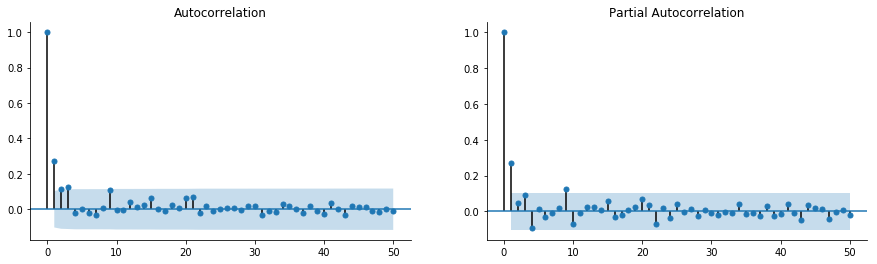

In [81]:
# ACF & PACF Plot of Residuals
acf_pacf_plot(res6.resid)

## Results

**SARIMA Model:**
    
- R^2 of the SARIMA model is 0.417
- RMSE of the SARIMA model is 0.0746
- MAE of the SARIMA model is 0.0537


**SARIMAX Model with coupons as external variable**

- R^2 of the SARIMAX model is 0.5206
- RMSE of the SARIMAX model is 0.0677
- MAE of the SARIMAX model is 0.0481
